<a href="https://colab.research.google.com/github/arashash/boolean-network-optimizer/blob/main/RBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Boolean Networks (Kauffman Networks)

**Github**: https://github.com/arashash/boolean-network-optimizer

**Slides**: https://slides.com/arashash/rbm-optimizer

**Acknowledgments**: Many thanks to [David Rolnick](http://www.davidrolnick.com/) for his invaluable feedback on the content. Also this tutorial is highly inspired from Neuromatch Academy style.




---
# Tutorial Objectives

*   Understaning what are RBMs and their known properties
*   How to implemnt them efficiently in Pytorch
*   How to optimize them to learn simple boolean functions



---
# Setup


In [1]:
#@title Imports
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from itertools import product
from graphviz import Digraph
from matplotlib import rc
import matplotlib.animation as animation
dev = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
#@title Figure Settings
%%capture
# uncomment for getting publication quality plots
# !apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
# !pip install SciencePlots
import matplotlib.pyplot as plt
# plt.style.use(['science', 'dark_background'])
rc('animation', html='jshtml')

In [3]:
#@title Helper Functions

# Introduction
A Boolean network consists of a discrete set of boolean variables each of which has a Boolean function (possibly different for each variable) assigned to it which takes inputs from a subset of those variables and output that determines the state of the variable it is assigned to. This set of functions in effect determines a topology (connectivity) on the set of variables, which then become nodes in a network. Usually, the dynamics of the system is taken as a discrete time series where the state of the entire network at time t+1 is determined by evaluating each variable's function on the state of the network at time t. This may be done synchronously or asynchronously.

Boolean networks have been used in biology to model regulatory networks. Although Boolean networks are a crude simplification of genetic reality where genes are not simple binary switches, there are several cases where they correctly capture the correct pattern of expressed and suppressed genes. The seemingly mathematical easy (synchronous) model was only fully understood in the mid 2000s.


### Attractors
Since a Boolean network has only $2^N$ possible states, a trajectory will sooner or later reach a previously visited state, and thus, since the dynamics are deterministic, the trajectory will fall into a steady state or cycle called an attractor (though in the broader field of dynamical systems a cycle is only an attractor if perturbations from it lead back to it). If the attractor has only a single state it is called a point attractor, and if the attractor consists of more than one state it is called a cycle attractor. The set of states that lead to an attractor is called the basin of the attractor. States which occur only at the beginning of trajectories (no trajectories lead to them), are called garden-of-Eden states and the dynamics of the network flow from these states towards attractors. The time it takes to reach an attractor is called transient time.

With growing computer power and increasing understanding of the seemingly simple model, different authors gave different estimates for the mean number and length of the attractors, here a brief summary of key publications.

<table>
  <tr>
    <th> Author </th>
    <th> Year </th>
    <th> Mean attractor lenght </th>
    <th> Mean attractor number </th>
    <th> comment </th>
  </tr>
  <tr>
    <td> Kauffmann <a href="https://doi.org/10.1038/224177a0"><sup>[1]</sup></a></td>
    <td> 1969 </td>
    <td> \begin{equation}\langle A\rangle \sim \sqrt{N}\end{equation} </td>
    <td> \begin{equation}\langle\nu\rangle \sim \sqrt{N}\end{equation} </td>
    <td> first time proposed </td>
  </tr>
  <tr>
    <td> Bastolla/ Parisi<a href="https://doi.org/10.1016%2FS0167-2789%2897%2900242-X"><sup>[2]</sup></a></td>
    <td> 1998 </td>
    <td> \begin{equation}\langle A\rangle>N^{x}~~\forall x\end{equation} </td>
    <td> \begin{equation}\langle A\rangle>N^{x}~~\forall x\end{equation} </td>
    <td> first numerical evidences </td>
  </tr>
    <tr>
    <td> Samuelsson/Troein <a href="https://doi.org/10.1103/PhysRevLett.90.098701"><sup>[3]</sup></a></td>
    <td> 2003 </td>
    <td>  </td>
    <td> superpolynomial growth
    <td> mathematical proof </td>
  </tr>
</table>

# Implementation

In [4]:
#@title
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="C2iuESiXRB4", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Video available at https://youtu.be/C2iuESiXRB4


In [5]:
# Topological variables
in_nodes = 5 # -> M
out_nodes = 5 # -> N
edges = 10 # -> P
total_nodes = out_nodes + in_nodes

In [6]:
# Network parameters
perms = [torch.randperm(total_nodes).view(1, -1) for _ in range(out_nodes)]
conectivity = torch.cat(perms)[:, :edges].to(dev) # -> C
conectivity = conectivity.reshape(out_nodes*edges)
# Note: stay tuned here for a batch mode of torch.randperm to avoid looping
# https://github.com/pytorch/pytorch/issues/42502

weights = (torch.rand(2**edges, out_nodes) > 0.5).to(dev) # -> W

In [7]:
# Training parameters
batch_size = 10 
num_batches = 1000
num_steps = 100 
tasks_num = 1 
outputs = torch.zeros(batch_size, num_steps, out_nodes).bool().to(dev)
# helper constant for binary to decimal conversion
bin_converter = 2**torch.arange(edges).long().to(dev)

In [8]:
# Training/Testing
for _ in range(tasks_num):
  code = (torch.rand(1, out_nodes) > 0.5).to(dev) # -> f
  error_rates = []
  for _ in range(num_batches):
    input = (torch.rand(batch_size, in_nodes) > 0.5).to(dev) # -> x
    out = torch.zeros(batch_size, out_nodes).bool().to(dev)  # -> y_hat
    target = input ^ code # -> y
    for i in range(num_steps):
      state = torch.cat([input, out], dim=1) # -> s
      node_inputs = torch.index_select(state, 1, conectivity) # -> I
      node_inputs = node_inputs.reshape(batch_size, out_nodes, edges)
      # indeces = node_inputs.long() @ bin_converter # -> m
      # NOTE: integer matrix multiplcation is not implemnted on GPU yet!
      # folow this issue: https://github.com/pytorch/pytorch/issues/44428
      # until then we could use this work-around
      indeces = (node_inputs.float() @ bin_converter.float()).long() # -> m

      out = torch.gather(weights, 0, indeces) # -> y_hat
      # out = torch.diagonal((weights[indeces]))
      outputs[:, i] = out

      if i == num_steps//2: # Testing
        test_outs = outputs[:, :num_steps//2]
        error_rate = torch.mean((test_outs^target[:,None,:]).float())
        error_rates += [error_rate]

      if i > num_steps//2: # Training
        error = torch.sum(out ^ target, axis=0) > batch_size//2
        # comment this out if you want to update anti-diagonals too
        error = error*torch.eye(out_nodes).bool().to(dev)
        for k in range(batch_size): 
          weights[indeces[k]] = weights[indeces[k]] ^ error

# Visualizations

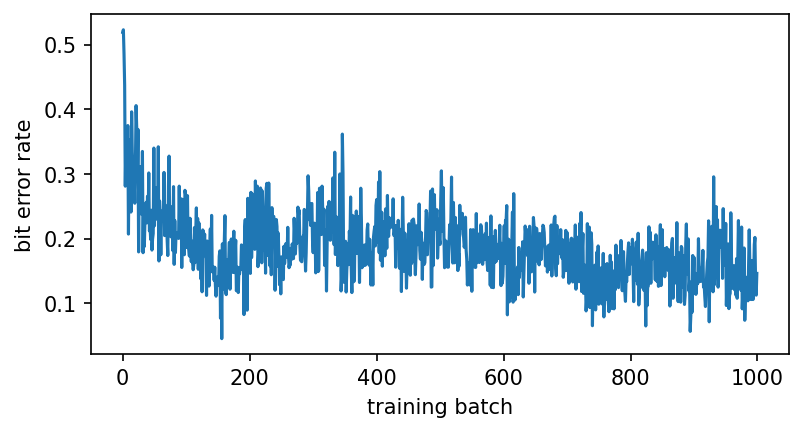

In [9]:
#@markdown Training plot
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
ax.plot(error_rates)
plt.ylabel('bit error rate')
plt.xlabel('training batch')
plt.savefig('training.png')

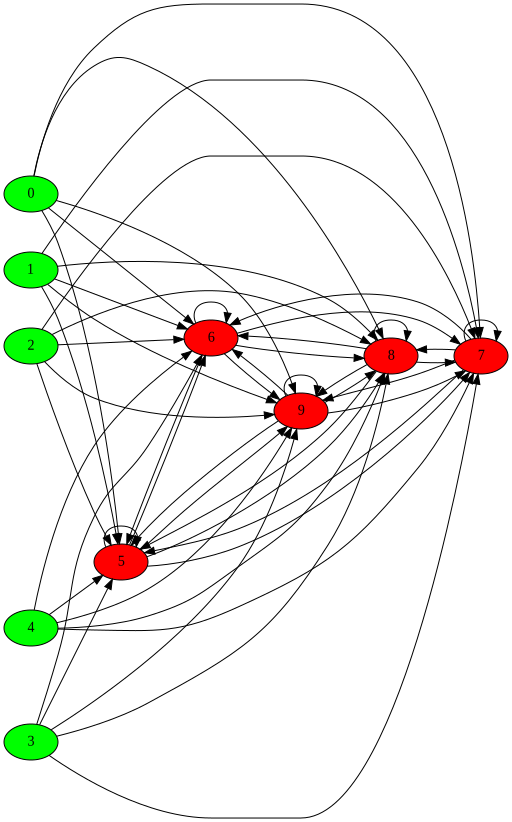

In [10]:
#@markdown Visualization of Graph
dot = Digraph(format='svg')
dot.attr(rankdir='LR')
dot.attr(bgcolor='transparent')

for m in range(in_nodes):
  dot.node(str(m), str(m), style='filled', fillcolor='green')

for n in range(out_nodes):
  dot.node(str(in_nodes+n), str(in_nodes+n), style='filled', fillcolor='red')

connections = []
conectivity = conectivity.reshape(out_nodes, edges)
for n, inputs in enumerate(conectivity.cpu().numpy()):
  for input in inputs:
    dot.edge(str(input), str(in_nodes+n))

dot.render('network', view=True)
dot

In [11]:
#@markdown Rastor Plot
sample_index = 0
state_times = outputs[sample_index, :num_steps//2]
state_times = state_times.T.cpu().numpy()*np.arange(1, num_steps//2+1)
colorCodes = np.random.rand(out_nodes, 3)
lineSize = np.linspace(0.4, 0.9, out_nodes)

fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
ax.set(xlim=(0, num_steps//2), ylim=(-0.4, out_nodes))
ax.yaxis.set_ticklabels([])
ims = []
for i in range(num_steps):
    ims.append(ax.eventplot(state_times[:, :i], color=colorCodes,
                            linelengths = lineSize))

im_ani = animation.ArtistAnimation(fig, ims, interval=200,
                                   repeat_delay=1000, blit=True)
# To save this second animation with some metadata, use the following command:
im_ani.save('im.mp4', metadata={'artist':'Arash'})
plt.close()
im_ani